<a href="https://colab.research.google.com/github/merrittharlan/SWOT_THP/blob/main/SWOT_GDL_Snow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code explores a preliminary analysis of Surface Water Ocean Topography (SWOT) satellite data products over glacial dammed lakes, using earthaccess. The first cell block includes parameters to change based on a given lake.

Parameters:

* lake_name: name of the lake
* sw_lat, sw_lon: southwest latitude and longitude coordinates respectively, in EPSG 4326
*   ne_lat, ne_lon: northeast latitude and longitude coordinates respectively, in EPSG 4326
* elev_min, elev_max: user defined bounds on a range on lake elevation values to filter between, in meters, for EGM2008 datum
* new_elev_min, new_elev_max: secondary set of user defined bounds on a range on lake elevation values to filter between, in meters, for EGM2008 datum
* start_date: date to begin querying SWOT observation data (nominally set to June 1, 2023
* end_date: date to end querying SWOT observation data (nominally set to the date this script was written, November 19, 2024)
* classification_values: SWOT pixels are classified into seven potential classes, described in further detail here: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/web-misc/swot_mission_docs/pdd/D-56411_SWOT_Product_Description_L2_HR_PIXC_20240913.pdf :
  * 1: land
  * 2: land near water
  * 3: water near land
  * 4: open water
  * 5: dark water
  * 6: low coherence water nearland
  * 7: open low coherence water
* new_classification: secondary set of user defined classification categories
* geolocation_qual_max: maximum geolocation quality flag value, similarly described in the Product Description Document linked above-- here we choose a value less than 29823 to remove all degraded and bad data (this value was calculated by adding up the bitwise quality values corresponding to the first 11 flags)


In [ ]:
### up front parameters to change
import geopandas as gpd

#lake name
lake_name = 'Snow'

from google.colab import files
uploaded = files.upload()

# Assuming the file you uploaded is named 'your_file.geojson'
Snow_outline = gpd.read_file('Snow_GDL.geojson')

#acceptable range(s) of elevation
elev_min, elev_max = 600, 1300
new_elev_min, new_elev_max = 600, 800

#dates to query data
start_date = '2023-04-01 00:00:00'
end_date = '2024-11-26 00:00:00'

#months to include
months_to_exclude = [12, 1, 2, 3, 4]

#SWOT classification values
classification_values = [3, 4, 5, 6, 7]
new_classification = [4]

#SWOT geolocation quality
geolocation_qual_max = 29823


Saving Snow_GDL.geojson to Snow_GDL.geojson


In [ ]:
import folium

# Calculate the bounding box from Snow_outline
bounds = Snow_outline.total_bounds  # [minx, miny, maxx, maxy]
sw_lat, sw_lon = bounds[1], bounds[0]  # (min_lat, min_lon)
ne_lat, ne_lon = bounds[3], bounds[2]  # (max_lat, max_lon)

# Create the folium map centered around the bounding box
lake_map = folium.Map(location=[(sw_lat + ne_lat) / 2, (sw_lon + ne_lon) / 2], zoom_start=12)

# Extract the geometry (coordinates) from Snow_outline and add it as a polygon
for geom in Snow_outline.geometry:
    if geom.geom_type == 'Polygon':  # Handle Polygon geometries
        coords = [(point[1], point[0]) for point in geom.exterior.coords]
        folium.Polygon(locations=coords, color="blue", weight=2, fill=True, fill_opacity=0.2).add_to(lake_map)
    elif geom.geom_type == 'MultiPolygon':  # Handle MultiPolygon geometries
        for poly in geom:
            coords = [(point[1], point[0]) for point in poly.exterior.coords]
            folium.Polygon(locations=coords, color="blue", weight=2, fill=True, fill_opacity=0.2).add_to(lake_map)

# Display the map
lake_map

In [ ]:
#!pip install earthaccess
import earthaccess
import xarray as xr

auth = earthaccess.login()

pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                        temporal = (start_date, end_date),
                                        bounding_box = (sw_lon, sw_lat, ne_lon, ne_lat))
len(pixc_results)

171

In [ ]:
import h5py
import numpy as np
import re

def filter_pixc_file(pixc_file, bounding_box,
                     classification_vals = classification_values,
                     geolocation_qual_th = geolocation_qual_max,
                     elev_min = elev_min, elev_max = elev_max):
    """
    Process an SWOT pixel netcdf file, crop data to a bounding box, apply filtering criteria, and return the filtered data.

    Args:
        pixc_file (str): Path to the SWOT pixel netcdf file
        bounding_box (tuple): A tuple of (sw_lon, sw_lat, ne_lon, ne_lat) defining the bounding box for filtering.
        classification_threshold (int): Minimum value for classification to include the data. Default is [3, 4, 5, 6, 7].
        geolocation_qual_threshold (int): Maximum value for geolocation_qual to include the data. Default is 29823.
        elev_min (int): Minimum elevation value to include the data.
        elev_max (int): Maximum elevation value to include the data.

    Returns:
        dict: A dictionary containing the filtered data for 'latitude', 'longitude', 'height',
              'classification', 'geolocation_qual', 'sig0', and 'geoid'.
    """

    # Extract date from the file URL (you may already have this logic elsewhere)
    url = pixc_file.full_name
    date_match = re.search(r'(\d{8})', url)
    date_str = date_match.group(1)

    # Open the HDF5 file
    with h5py.File(pixc_file, 'r') as f:
        # Access the pixel_cloud group
        group = f['pixel_cloud']

        # Get the latitude and longitude arrays
        latitudes = group['latitude'][:]

        # Apply bounding box filter (lat_mask and lon_mask)
        lat_mask = (latitudes >= bounding_box[1]) & (latitudes <= bounding_box[3])

        # If no data within bounding box, return early to avoid loading unnecessary variables
        if not np.any(lat_mask):
            return {
                'latitudes': np.array([]),
                'longitudes': np.array([]),
                'height': np.array([]),
                'elevation': np.array([]),
                'classification': np.array([]),
                'geolocation_qual': np.array([]),
                'sig0': np.array([]),
                'geoid': np.array([]),
                'url': url,
                'date': date_str
            }

        longitudes = group['longitude'][:]
        lon_mask = (longitudes >= bounding_box[0]) & (longitudes <= bounding_box[2])

        # If no data within bounding box, return early to avoid loading unnecessary variables
        if not np.any(lat_mask & lon_mask):
            return {
                'latitudes': np.array([]),
                'longitudes': np.array([]),
                'height': np.array([]),
                'elevation': np.array([]),
                'classification': np.array([]),
                'geolocation_qual': np.array([]),
                'sig0': np.array([]),
                'geoid': np.array([]),
                'url': url,
                'date': date_str
            }

        # Combine lat and lon masks
        combined_mask = lat_mask & lon_mask

        # Load only the necessary variables using the combined mask
        lat_cropped = latitudes[combined_mask]
        lon_cropped = longitudes[combined_mask]

        # Crop the variables that are needed and have data
        height = group['height'][combined_mask]
        classification = group['classification'][combined_mask]
        geolocation_qual = group['geolocation_qual'][combined_mask]
        sig0 = group['sig0'][combined_mask]
        geoid = group['geoid'][combined_mask]

        # Calculate elevation as the sum of height and geoid
        elevation = height - geoid

        # Store the cropped data in a dictionary
        cropped_data = {
            'latitudes': lat_cropped,
            'longitudes': lon_cropped,
            'height': height,
            'classification': classification,
            'geolocation_qual': geolocation_qual,
            'sig0': sig0,
            'geoid': geoid,
            'elevation': elevation,
            'url': url,
            'date': date_str
        }

        # Apply filter conditions for classification, geolocation quality, and elevation
        filter_mask = np.isin(cropped_data['classification'], classification_vals) & \
              (cropped_data['geolocation_qual'] < geolocation_qual_th) & \
              (cropped_data['elevation'] > elev_min) & \
              (cropped_data['elevation'] < elev_max)

          # Apply the filter to all variables in the cropped_data dictionary
        filtered_data = {}

        # Loop through the cropped data to filter each variable
        for key, value in cropped_data.items():
            if isinstance(value, np.ndarray):  # Only apply the filter to numpy arrays
                filtered_data[key] = value[filter_mask]
            else:
                filtered_data[key] = value  # Add non-array items as they are (date, url)

        # Return the filtered data dictionary, including 'date' and 'url'
        return filtered_data

# Example usage:
bounding_box = (sw_lon, sw_lat, ne_lon, ne_lat)
fileset = earthaccess.open(pixc_results[0:1])
filtered_data = filter_pixc_file(fileset[0], bounding_box)

# Example: print filtered height data
print("Filtered height data shape:", filtered_data['height'].shape)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Filtered height data shape: (3201,)


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

def process_multiple_files_parallel(files, bounding_box,
                                    classification_vals = classification_values,
                                    geolocation_qual_th = geolocation_qual_max,
                                    elev_min = elev_min, elev_max = elev_max):
    """
    Apply the filter_pixc_file function to multiple files concurrently and return a list of filtered data.
    """
    all_filtered_data = []

    # Flatten the files if they are in a list of lists
    flat_files = [file for sublist in files for file in sublist] if isinstance(files[0], list) else files

    start_time = time.time()  # Start timing the process

    # Use ThreadPoolExecutor for parallel execution
    with ThreadPoolExecutor() as executor:
        # Submit each file processing task to the executor
        future_to_file = {executor.submit(filter_pixc_file, file,
                                          bounding_box, classification_vals,
                                          geolocation_qual_th, elev_min, elev_max): file for file in flat_files}

        # Wait for each task to complete and collect results
        for future in as_completed(future_to_file):
            filtered_data = future.result()
            all_filtered_data.append(filtered_data)

    end_time = time.time()  # End timing the process
    elapsed_time = end_time - start_time
    print(f"Processing took {elapsed_time:.2f} seconds.")

    # Count and print how many observations have non-empty data
    non_empty_count = 0
    for data in all_filtered_data:
        if data['height'].size > 0:  # Check if 'height' has data
            non_empty_count += 1

    print(f"Number of files with non-empty data rows: {non_empty_count}")

    return all_filtered_data

In [ ]:
# Process all files concurrently
all_pixc_files = [earthaccess.open(pixc_results)]
filtered_data_list = process_multiple_files_parallel(all_pixc_files, bounding_box)

QUEUEING TASKS | :   0%|          | 0/171 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/171 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/171 [00:00<?, ?it/s]

Processing took 5060.00 seconds.
Number of files with non-empty data rows: 77


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/us

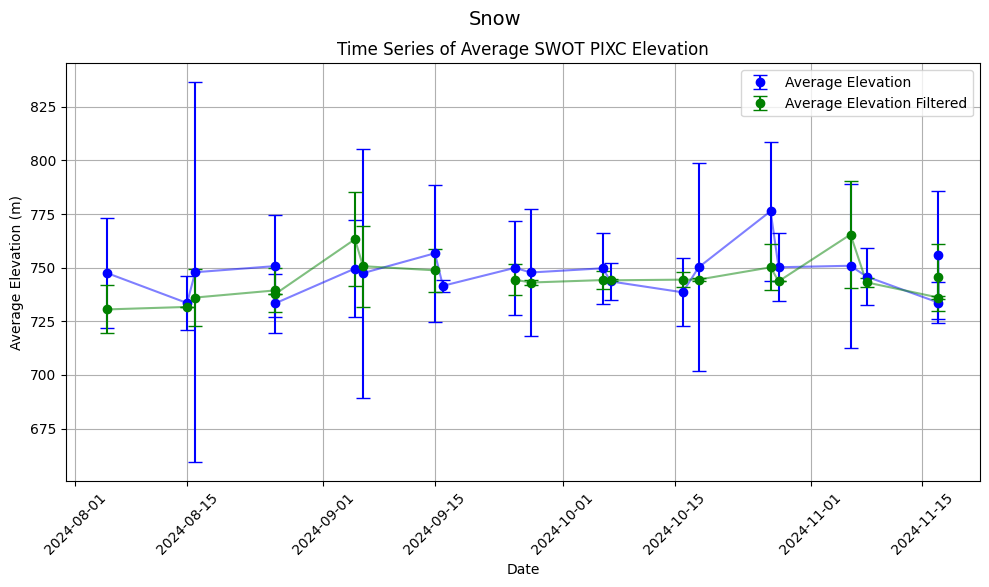

         Date  Average Elevation    Std Dev  Pixel Count  \
2  2024-08-05         747.486938  25.658461         3702   
4  2024-08-15         733.528259  12.587068           70   
7  2024-08-16         747.891968  88.539513         2902   
3  2024-08-26         750.756836  23.830196         3477   
13 2024-08-26         733.357971  13.777618          169   
8  2024-09-05         749.627991  22.568247         1180   
10 2024-09-06         747.488647  58.003899         3874   
15 2024-09-15         756.745850  32.046387         3050   
12 2024-09-16         741.566162   2.724692           22   
17 2024-09-25         749.945496  21.868452         1461   
19 2024-09-27         747.780212  29.630346         5146   
21 2024-10-06         749.741821  16.573576         2545   
20 2024-10-07         743.608643   8.590920          748   
22 2024-10-16         738.539551  15.879191         1473   
24 2024-10-18         750.195801  48.482468          230   
26 2024-10-27         776.368835  32.360

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def aggregate_data_and_plot(filtered_data_list, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max):
    """
    Aggregates data from each file by calculating the average elevation
    and plots a timeseries of average elevation over time with error bars.

    Args:
        filtered_data_list (list): A list of dictionaries containing filtered data from each file.

    Returns:
        pd.DataFrame: A dataframe containing the date and average elevation for each file.
    """
    # Prepare lists to hold dates, average elevations, and standard deviations
    dates = []
    avg_elevations = []
    std_devs = []
    avg_elevations_filtered = []
    std_devs_filtered = []
    obs_ids = []
    obs_count = []
    obs_count_filtered = []

    # Loop through each file's filtered data and extract date, average elevation, and standard deviation
    for data in filtered_data_list:
        date = data['date']
        url = data['url']
        elevation = data['elevation']
        classification = data['classification']

        match = re.search(r'(\d{8})', url)  # Looks for an 8-digit sequence
        if match:
            extracted_date = match.group(1)
            # Extract the 10 characters before the date in the URL
            obs_id = url[max(0, match.start() - 9):match.end()]
        else:
            extracted_date = np.nan
            obs_id = np.nan

        # Filter elevation data based on classification and elevation range for each point
        filter_mask = np.isin(classification, new_classification) & \
              (elevation > new_elev_min) & \
              (elevation < new_elev_max)

        filtered_elevation = elevation[filter_mask]

        # Calculate average and std deviation for unfiltered data
        avg_elevation = np.mean(elevation)
        std_dev = np.std(elevation)

        # Calculate average and std deviation for filtered data
        avg_elevation_filtered = np.mean(filtered_elevation)
        std_dev_filtered = np.std(filtered_elevation)

        # Observation counts
        obs_count.append(len(elevation))  # Unfiltered observation count
        obs_count_filtered.append(len(filtered_elevation))  # Filtered observation count

        # Append data to the lists
        dates.append(date)
        avg_elevations.append(avg_elevation)
        std_devs.append(std_dev)
        avg_elevations_filtered.append(avg_elevation_filtered)
        std_devs_filtered.append(std_dev_filtered)
        obs_ids.append(obs_id)

    # Create a DataFrame to hold the aggregated data

    df = pd.DataFrame({
        'Date': dates,
        'Average Elevation': avg_elevations,
        'Std Dev': std_devs,
        'Pixel Count': obs_count,
        'Average Elevation Filtered': avg_elevations_filtered,
        'Std Dev Filtered': std_devs_filtered,
        'Pixel Count Filtered': obs_count_filtered,
        'Observation ID': obs_ids
    })

    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.dropna(subset=['Average Elevation', 'Std Dev'])

    df = df.sort_values(by='Date')

    # Plot the time series with error bars and a line through the points
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['Date'], df['Average Elevation'], yerr=df['Std Dev'], fmt='o', color='b', label='Average Elevation', capsize=5)
    plt.plot(df['Date'], df['Average Elevation'], color='b', linestyle='-', alpha=0.5)  # Draw a line through the points
    plt.errorbar(df['Date'], df['Average Elevation Filtered'], yerr=df['Std Dev Filtered'], fmt='o', color='g', label='Average Elevation Filtered', capsize=5)
    plt.plot(df['Date'], df['Average Elevation Filtered'], color='g', linestyle='-', alpha=0.5)  # Draw a line through the points
    plt.xlabel('Date')
    plt.ylabel('Average Elevation (m)')
    plt.title('Time Series of Average SWOT PIXC Elevation')
    plt.suptitle(lake_name, fontsize=14, y=0.97)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df

# Aggregate the data and plot the time series
df_avg_elevation = aggregate_data_and_plot(filtered_data_list, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max)

# Display the resulting DataFrame
print(df_avg_elevation)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/us

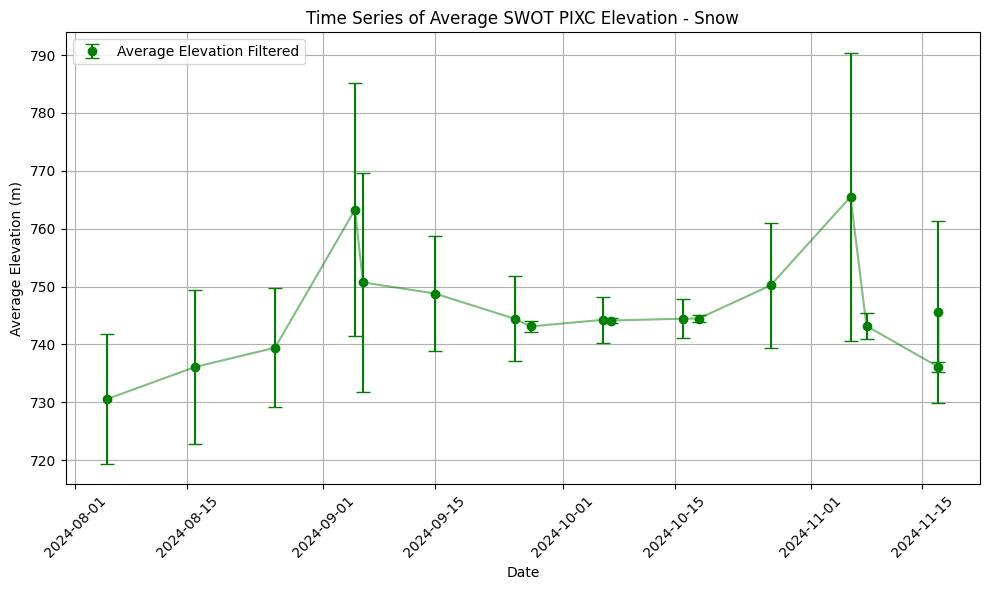

         Date  Average Elevation Filtered  Std Dev Filtered  \
2  2024-08-05                  730.570374         11.177786   
7  2024-08-16                  736.096680         13.330463   
3  2024-08-26                  739.424500         10.282511   
8  2024-09-05                  763.294739         21.843504   
10 2024-09-06                  750.710938         18.876057   
15 2024-09-15                  748.796387          9.958192   
17 2024-09-25                  744.419800          7.337159   
19 2024-09-27                  743.107300          0.971769   
21 2024-10-06                  744.242004          4.009948   
20 2024-10-07                  744.129150          0.390689   
22 2024-10-16                  744.442993          3.360337   
24 2024-10-18                  744.472473          0.645876   
26 2024-10-27                  750.200562         10.803536   
28 2024-11-06                  765.487427         24.897932   
32 2024-11-08                  743.176208          2.19

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

def aggregate_data_and_plot(filtered_data_list, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max):
    """
    Aggregates data from each file by calculating the average elevation
    and plots a timeseries of average elevation over time with error bars.

    Args:
        filtered_data_list (list): A list of dictionaries containing filtered data from each file.

    Returns:
        pd.DataFrame: A dataframe containing the date and average elevation for each file.
    """
    # Prepare lists to hold dates, average elevations, and standard deviations
    dates = []
    avg_elevations_filtered = []
    std_devs_filtered = []
    obs_ids = []
    obs_count_filtered = []

    # Loop through each file's filtered data and extract date, average elevation, and standard deviation
    for data in filtered_data_list:
        date = data['date']
        url = data['url']
        elevation = data['elevation']
        classification = data['classification']

        match = re.search(r'(\d{8})', url)  # Looks for an 8-digit sequence
        if match:
            extracted_date = match.group(1)
            # Extract the 10 characters before the date in the URL
            obs_id = url[max(0, match.start() - 9):match.end()]
        else:
            extracted_date = np.nan
            obs_id = np.nan

        # Filter elevation data based on classification and elevation range for each point
        filter_mask = np.isin(classification, new_classification) & \
              (elevation > new_elev_min) & \
              (elevation < new_elev_max)

        filtered_elevation = elevation[filter_mask]

        # Calculate average and std deviation for filtered data
        avg_elevation_filtered = np.mean(filtered_elevation)
        std_dev_filtered = np.std(filtered_elevation)

        # Observation counts for filtered data
        obs_count_filtered.append(len(filtered_elevation))  # Filtered observation count

        # Append data to the lists
        dates.append(date)
        avg_elevations_filtered.append(avg_elevation_filtered)
        std_devs_filtered.append(std_dev_filtered)
        obs_ids.append(obs_id)

    # Create a DataFrame to hold the aggregated data
    df = pd.DataFrame({
        'Date': dates,
        'Average Elevation Filtered': avg_elevations_filtered,
        'Std Dev Filtered': std_devs_filtered,
        'Pixel Count Filtered': obs_count_filtered,
        'Observation ID': obs_ids
    })

    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.dropna(subset=['Average Elevation Filtered', 'Std Dev Filtered'])

    # Filter out data with fewer than 20 data points (filtered observations)
    df = df[df['Pixel Count Filtered'] > 20]

    # Exclude data points where the month is between December and April (inclusive)
    df = df[~df['Date'].dt.month.isin(months_to_exclude)]

    # Sort the DataFrame by Date
    df = df.sort_values(by='Date')

    # Plot the time series for filtered data with error bars
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['Date'], df['Average Elevation Filtered'], yerr=df['Std Dev Filtered'], fmt='o', color='g', label='Average Elevation Filtered', capsize=5)
    plt.plot(df['Date'], df['Average Elevation Filtered'], color='g', linestyle='-', alpha=0.5)  # Draw a line through the points
    plt.xlabel('Date')
    plt.ylabel('Average Elevation (m)')
    plt.title(f'Time Series of Average SWOT PIXC Elevation - {lake_name}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df

# Aggregate the data and plot the time series for the filtered data with more than 20 data points and excluding Dec-Apr
df_avg_elevation_filtered = aggregate_data_and_plot(filtered_data_list, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max)

# Display the resulting DataFrame for filtered data
print(df_avg_elevation_filtered)




Filtered points after geometry check: 0
Filtered points after geometry check: 0
Filtered points after geometry check: 746
Filtered points after geometry check: 847
Filtered points after geometry check: 4
Filtered points after geometry check: 0
Filtered points after geometry check: 0
Filtered points after geometry check: 1028
Filtered points after geometry check: 82
Filtered points after geometry check: 0
Filtered points after geometry check: 1023
Filtered points after geometry check: 0
Filtered points after geometry check: 0
Filtered points after geometry check: 1
Filtered points after geometry check: 0
Filtered points after geometry check: 818
Filtered points after geometry check: 0
Filtered points after geometry check: 856
Filtered points after geometry check: 0
Filtered points after geometry check: 982
Filtered points after geometry check: 562
Filtered points after geometry check: 887
Filtered points after geometry check: 412
Filtered points after geometry check: 0
Filtered points a

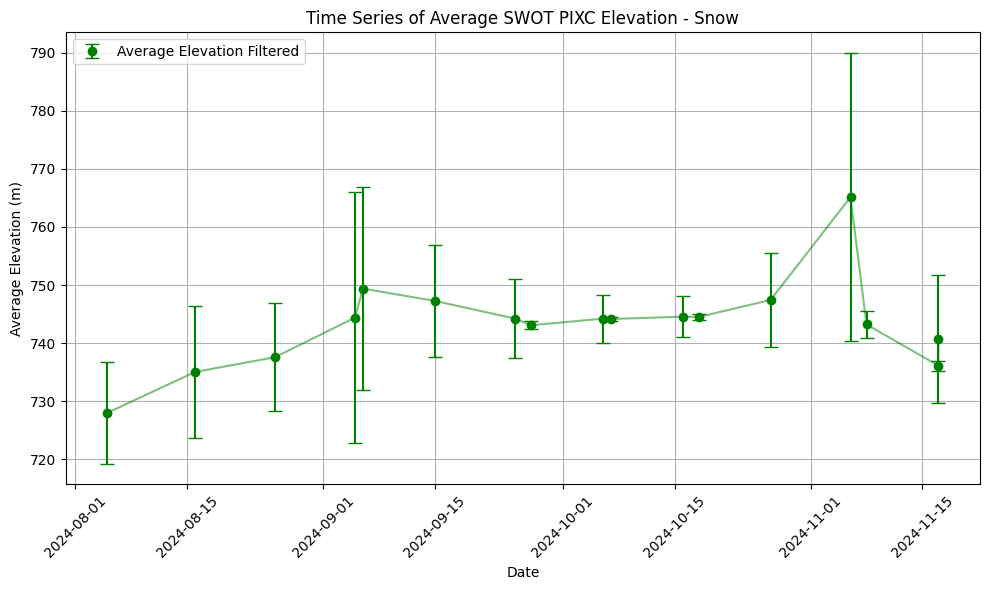

         Date  Average Elevation Filtered  Std Dev Filtered  \
0  2024-08-05                  728.001099          8.735830   
3  2024-08-16                  735.042053         11.294864   
1  2024-08-26                  737.584290          9.347071   
4  2024-09-05                  744.393433         21.560812   
5  2024-09-06                  749.384521         17.483829   
7  2024-09-15                  747.264526          9.598960   
8  2024-09-25                  744.238892          6.751797   
9  2024-09-27                  743.082092          0.706562   
11 2024-10-06                  744.212646          4.146546   
10 2024-10-07                  744.156860          0.353498   
12 2024-10-16                  744.554626          3.579959   
13 2024-10-18                  744.495544          0.561913   
14 2024-10-27                  747.436035          8.064133   
16 2024-11-06                  765.127563         24.829145   
19 2024-11-08                  743.219604          2.26

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon
import geopandas as gpd
from shapely.ops import transform
import pyproj

def aggregate_data_and_plot_with_geometry(filtered_data_list, Snow_outline, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max):
    """
    Aggregates data from each file by calculating the average elevation
    and plots a time series of average elevation over time with error bars.
    Filters the points based on geometry (polygon or multipolygon).

    Args:
        filtered_data_list (list): A list of dictionaries containing filtered data from each file.
        Snow_outline (GeoDataFrame or similar): The Snow outline geometry (polygon or multipolygon) to filter points by.

    Returns:
        pd.DataFrame: A dataframe containing the date and average elevation for each file, excluding points outside the geometry.
    """
    # Make sure Snow_outline is a GeoDataFrame
    if not isinstance(Snow_outline, gpd.GeoDataFrame):
        Snow_outline = gpd.read_file(Snow_outline)  # Read GeoJSON if it's not a GeoDataFrame yet

    # Ensure the CRS is the same for both filtered points and Snow_outline geometry
    # GeoDataFrame should be in the same CRS (WGS84, EPSG:4326) for proper point-in-polygon comparison
    target_crs = "EPSG:4326"  # WGS84 (longitude, latitude)
    if Snow_outline.crs != target_crs:
        Snow_outline = Snow_outline.to_crs(target_crs)

    # Prepare lists to hold dates, average elevations, and standard deviations
    dates = []
    avg_elevations_filtered = []
    std_devs_filtered = []
    obs_ids = []
    obs_count_filtered = []

    # Loop through each file's filtered data and extract date, average elevation, and standard deviation
    for data in filtered_data_list:
        date = data['date']
        url = data['url']
        elevation = data['elevation']
        classification = data['classification']
        latitudes = data['latitudes']  # Assuming latitudes are provided for each data point
        longitudes = data['longitudes']  # Assuming longitudes are provided for each data point

        match = re.search(r'(\d{8})', url)  # Looks for an 8-digit sequence
        if match:
            extracted_date = match.group(1)
            # Extract the 10 characters before the date in the URL
            obs_id = url[max(0, match.start() - 9):match.end()]
        else:
            extracted_date = np.nan
            obs_id = np.nan

        # Filter elevation data based on classification and elevation range for each point
        filter_mask = np.isin(classification, new_classification) & \
              (elevation > new_elev_min) & \
              (elevation < new_elev_max)

        filtered_elevation = elevation[filter_mask]
        filtered_latitudes = latitudes[filter_mask]
        filtered_longitudes = longitudes[filter_mask]

        # Create Shapely Point objects for each filtered latitude/longitude
        points = [Point(lon, lat) for lon, lat in zip(filtered_longitudes, filtered_latitudes)]

        # Filter points based on whether they are inside the Snow_outline geometry
        for geom in Snow_outline.geometry:
            # Handle Polygon or MultiPolygon geometries
            if geom.geom_type == 'Polygon':
                polygon = geom
            elif geom.geom_type == 'MultiPolygon':
                # For MultiPolygon, check each polygon in the multipolygon
                polygon = geom

            # Filter points that are inside the geometry (polygon or multipolygon)
            inside_polygon_mask = [polygon.contains(point) for point in points]

            # Keep only the points inside the polygon
            filtered_elevation = filtered_elevation[inside_polygon_mask]
            filtered_latitudes = filtered_latitudes[inside_polygon_mask]
            filtered_longitudes = filtered_longitudes[inside_polygon_mask]

        # Debugging: Check if there are any filtered points after geometry filtering
        print(f"Filtered points after geometry check: {len(filtered_elevation)}")

        # Append data to the lists if there are any valid points remaining
        if len(filtered_elevation) > 0:
            avg_elevation_filtered = np.mean(filtered_elevation)
            std_dev_filtered = np.std(filtered_elevation)

            obs_count_filtered.append(len(filtered_elevation))  # Filtered observation count

            dates.append(date)
            avg_elevations_filtered.append(avg_elevation_filtered)
            std_devs_filtered.append(std_dev_filtered)
            obs_ids.append(obs_id)

    # Create a DataFrame to hold the aggregated data
    df = pd.DataFrame({
        'Date': dates,
        'Average Elevation Filtered': avg_elevations_filtered,
        'Std Dev Filtered': std_devs_filtered,
        'Pixel Count Filtered': obs_count_filtered,
        'Observation ID': obs_ids
    })

    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.dropna(subset=['Average Elevation Filtered', 'Std Dev Filtered'])

    # Filter out data with fewer than 20 data points (filtered observations)
    df = df[df['Pixel Count Filtered'] > 20]

    # Exclude data points where the month is between December and April (inclusive)
    df = df[~df['Date'].dt.month.isin([12, 1, 2, 3, 4])]

    # Sort the DataFrame by Date
    df = df.sort_values(by='Date')

    # Plot the time series for filtered data
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['Date'], df['Average Elevation Filtered'], yerr=df['Std Dev Filtered'], fmt='o', color='g', label='Average Elevation Filtered', capsize=5)
    plt.plot(df['Date'], df['Average Elevation Filtered'], color='g', linestyle='-', alpha=0.5)  # Draw a line through the points
    plt.xlabel('Date')
    plt.ylabel('Average Elevation (m)')
    plt.title(f'Time Series of Average SWOT PIXC Elevation - {lake_name}')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df

# Example call to the function with Snow_outline (GeoDataFrame) and filtered_data_list
df_avg_elevation_filtered = aggregate_data_and_plot_with_geometry(filtered_data_list, Snow_outline, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max)

# Display the resulting DataFrame for filtered data
print(df_avg_elevation_filtered)

